In [131]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
%matplotlib inline

In [37]:
DEBUG = True

In [472]:
# Utility functions
def save_to_output(img, original_file, subdir, base_name):
    if DEBUG:
        subdir_path = "output_images/{}".format(subdir)
        if not os.path.exists(subdir_path):
            os.mkdir(subdir_path)

        output_file = os.path.join(subdir_path,"{}_{}".format(base_name, os.path.basename(original_file)))
        mpimg.imsave(output_file, img)
    
def plot_img(img, title):
    fig = plt.figure()
    fig.suptitle(title)
    plt.imshow(img)

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [138]:
# Calibrate camera
images = glob.glob('./camera_cal/calibration*.jpg')
nx=9
ny=6
objpoints = []
imgpoints = []
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

for image_file in images:
    img = mpimg.imread(image_file)
    gray = grayscale(img)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    corners_img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
    save_to_output(corners_img, image_file, "camera_calibration", "calibrated")
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

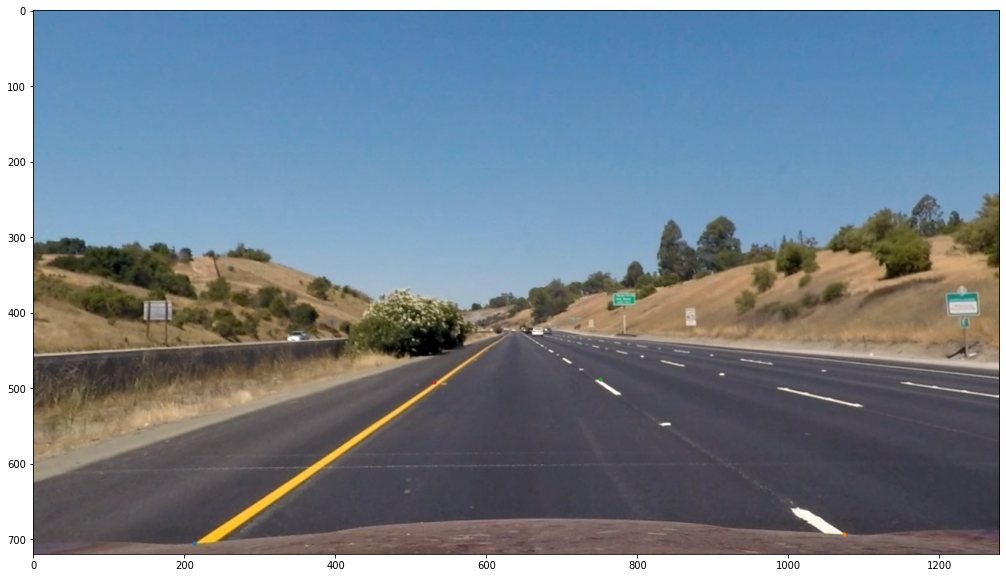

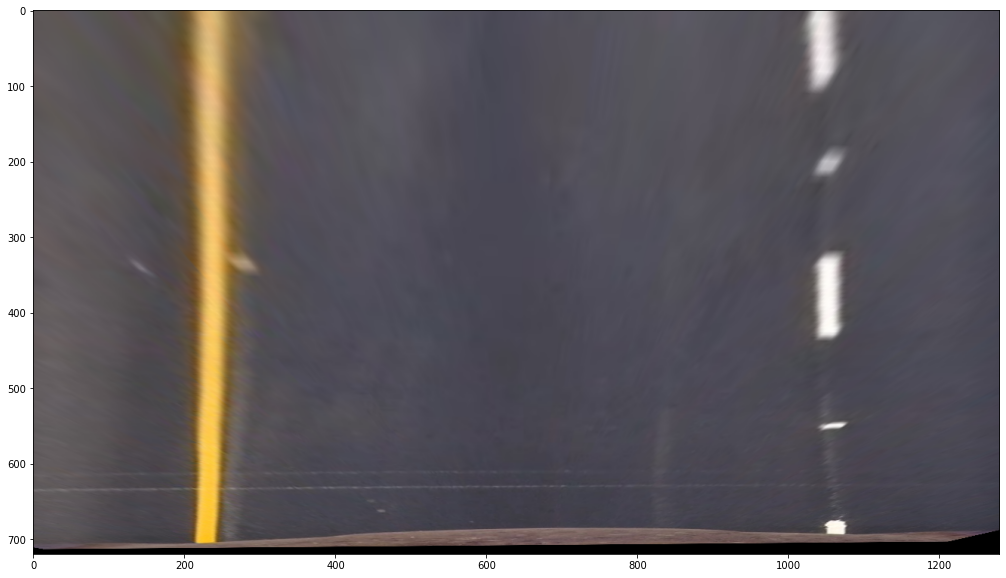

In [137]:
# Determine Perspective Transform
straight_img = mpimg.imread("test_images/straight_lines1.jpg")
undistorted = undistort(straight_img, mtx, dist)
undistorted_size = (undistorted.shape[1], undistorted.shape[0])
fig = plt.figure(figsize=(20,10))
plt.imshow(undistorted)
plt.plot(213, 705, ".")
plt.plot(1074, 693, ".")
plt.plot(750, 488, ".")
plt.plot(531, 492, ".")

src = np.float32([[213, 705], [1074, 693], [750, 488], [531, 492]])
dest = np.float32([[213, 705], [1074, 693], [1074, 317], [213, 317]])
M = cv2.getPerspectiveTransform(src, dest)
warped = cv2.warpPerspective(undistorted, M, undistorted_size, flags=cv2.INTER_LINEAR)
fig = plt.figure(figsize=(20,10))
plt.imshow(warped)

In [178]:
def hls_select(img, s_thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    S = hls[:,:,2]
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#     ax1.imshow(H, cmap='gray')
#     ax2.imshow(S, cmap='gray')
    binary_output = np.zeros_like(S)
    binary_output[(S >= s_thresh[0]) & (S <= s_thresh[1])] = 1
    return binary_output


In [482]:
def find_lane_pixels(thresh_binary):
    out_img = np.dstack((thresh_binary, thresh_binary, thresh_binary)) * 255
    left_lane_inds = []
    right_lane_inds = []
    
    histogram = np.sum(thresh_binary[thresh_binary.shape[0]//2:,:], axis=0)
    midpoint=int(histogram.shape[0]//2)
    leftx_base=np.argmax(histogram[:midpoint])
    rightx_base=np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    margin = 100
    minpix = 50
    window_height = int(thresh_binary.shape[0]//nwindows)
    nonzero=thresh_binary.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    for window in range(nwindows):
        win_y_low = thresh_binary.shape[0] - (window+1)*window_height
        win_y_high = thresh_binary.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
#         cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2) 
#         cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,0), 2)
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))  
        
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))
            
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
        
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return out_img, leftx, lefty, rightx, righty

def fit_poly(leftx, lefty, rightx, righty, y_step):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, y_step - 1, y_step)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty
    

def pipeline(img, s_thresh=(170, 200), sx_thresh=(20, 100), h_thresh=(0, 50)):
    img = np.copy(img)
    
    undistorted = undistort(img, mtx, dist)
    img_size = (undistorted.shape[1], undistorted.shape[0])
    
    warped = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)
    
    hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
#     ax1.imshow(h_channel, cmap='gray')
#     ax2.imshow(l_channel, cmap='gray')
#     ax3.imshow(s_channel, cmap='gray')
    
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    h_binary = np.ones_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= s_thresh[1])] = 0
    
    color_binary = np.zeros_like(h_binary)
    color_binary[(s_binary == 1) & (h_binary == 1)] = 1
    
    # Stack each channel
    out_img = np.dstack(( np.zeros_like(sxbinary), sxbinary, color_binary)) * 255

    thresh_binary = np.zeros_like(color_binary)
    thresh_binary[(color_binary == 1) | (sxbinary == 1)] = 1
    
    out_img, leftx, lefty, rightx, righty = find_lane_pixels(thresh_binary)
    left_fitx, right_fitx, ploty = fit_poly(leftx, lefty, rightx, righty, thresh_binary.shape[0])
    
    left_pts = np.column_stack((left_fitx, ploty))
    right_pts = np.flipud(np.column_stack((right_fitx, ploty)))
    window_pts = np.int_([np.concatenate((left_pts, right_pts))])
    
    lane_region = np.zeros_like(undistorted)
    cv2.fillPoly(lane_region, window_pts, (0, 255, 0))
    lane_region_unwarped = cv2.warpPerspective(lane_region, np.linalg.inv(M), img_size, flags=cv2.INTER_LINEAR)
    
    return weighted_img(lane_region_unwarped, undistorted)

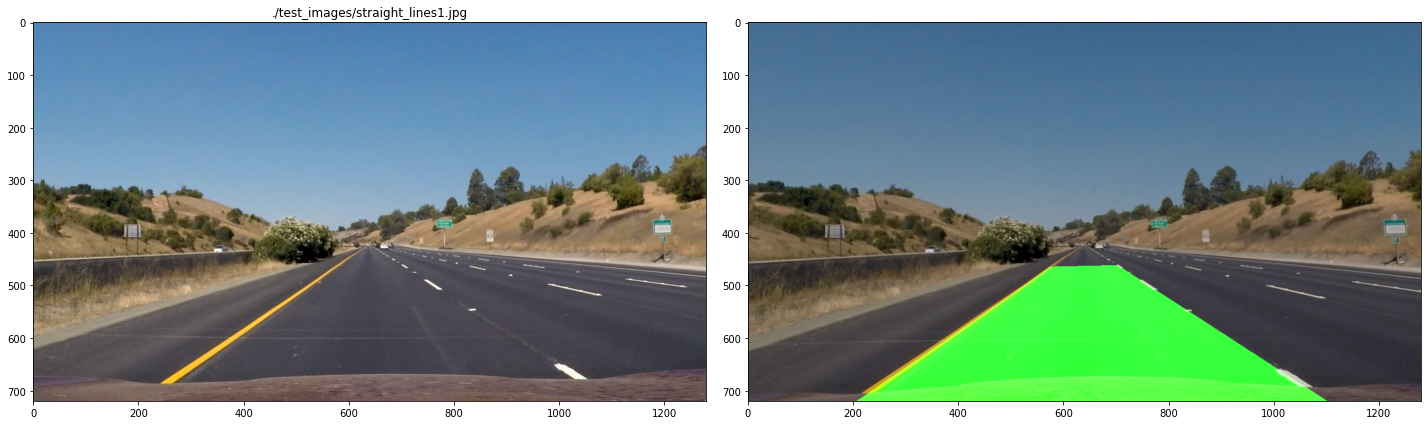

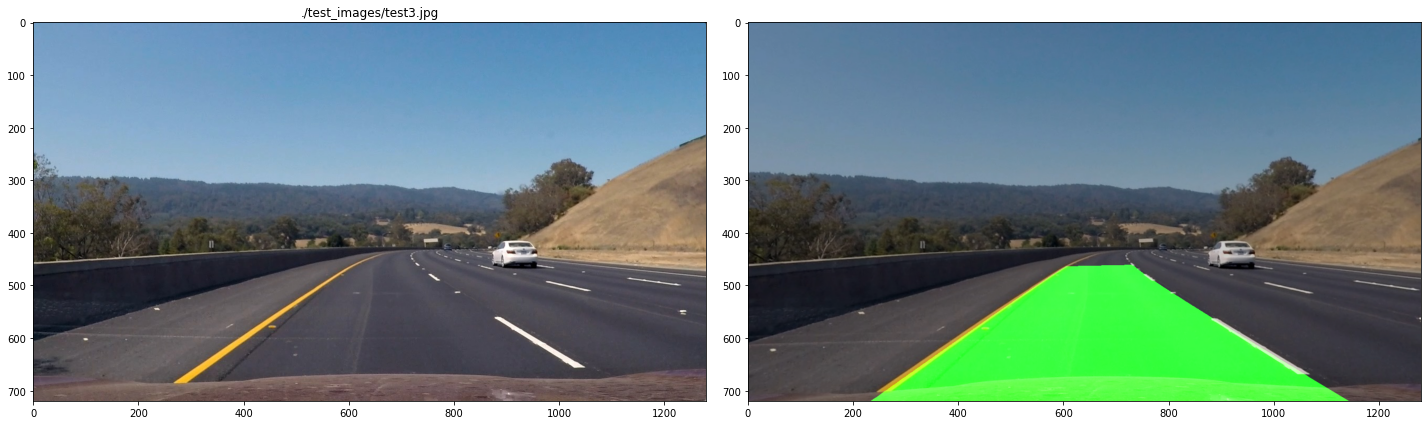

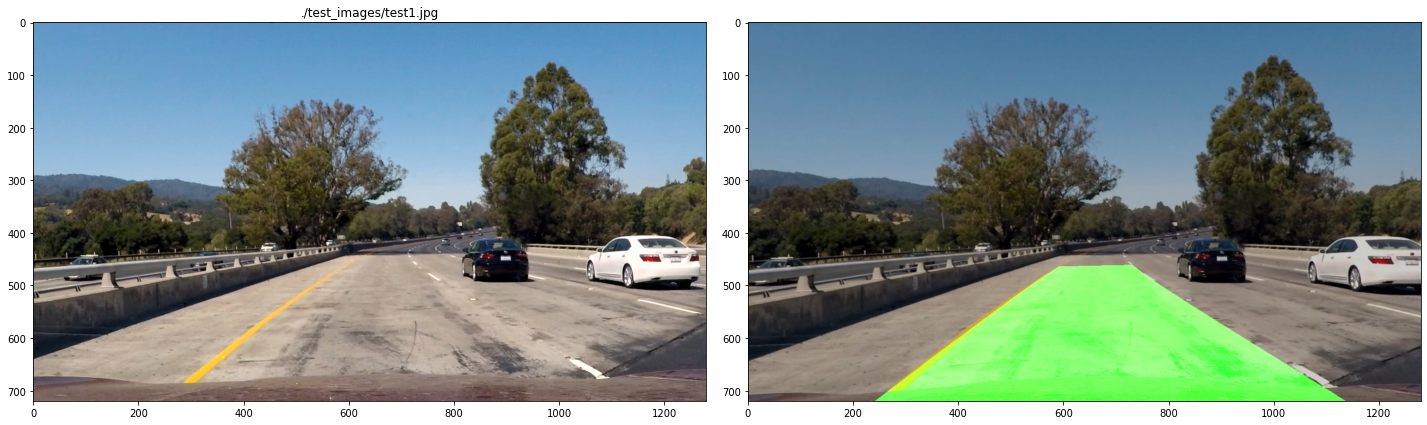

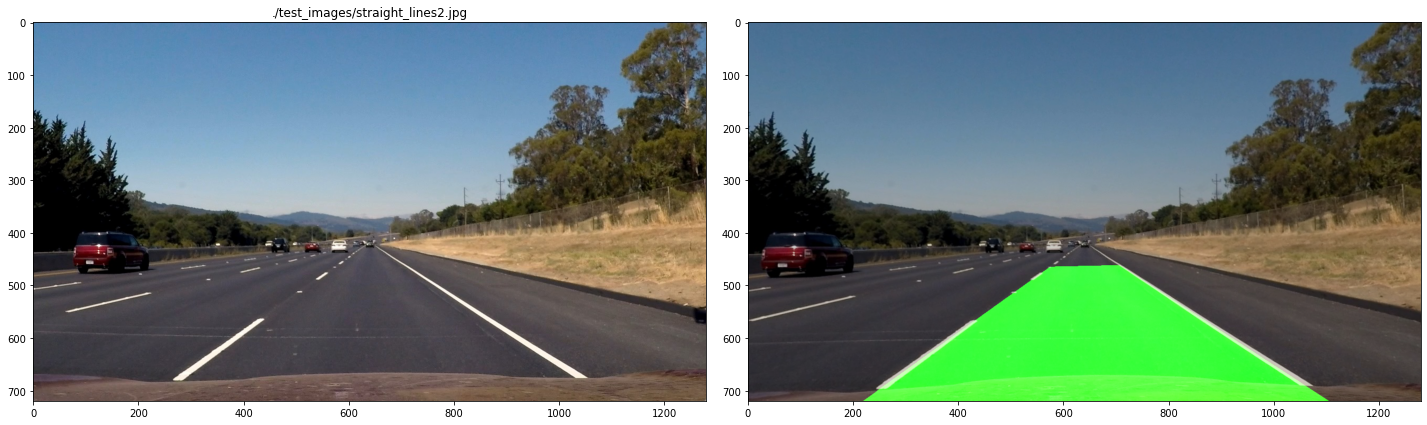

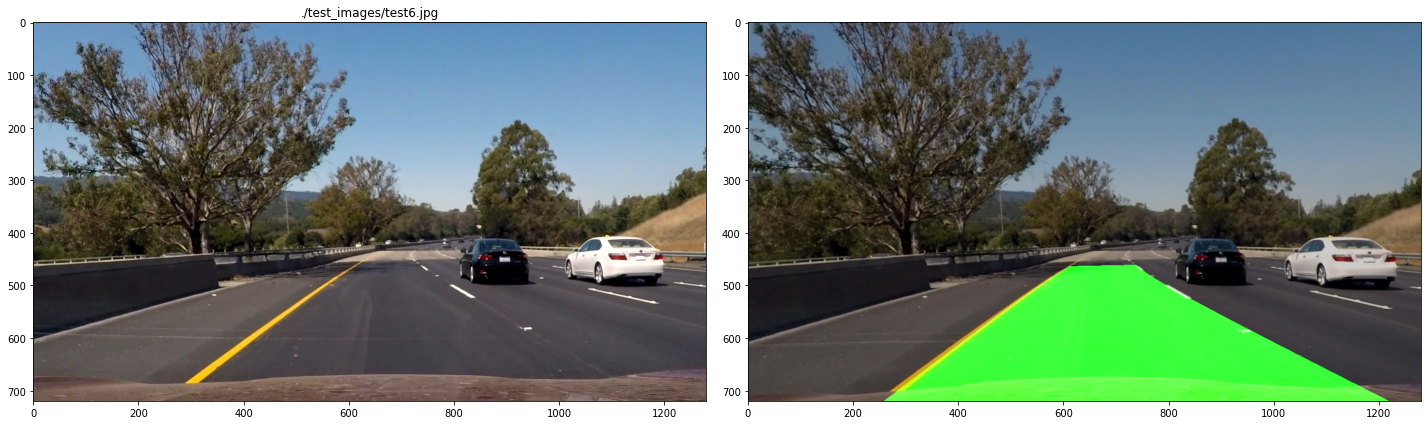

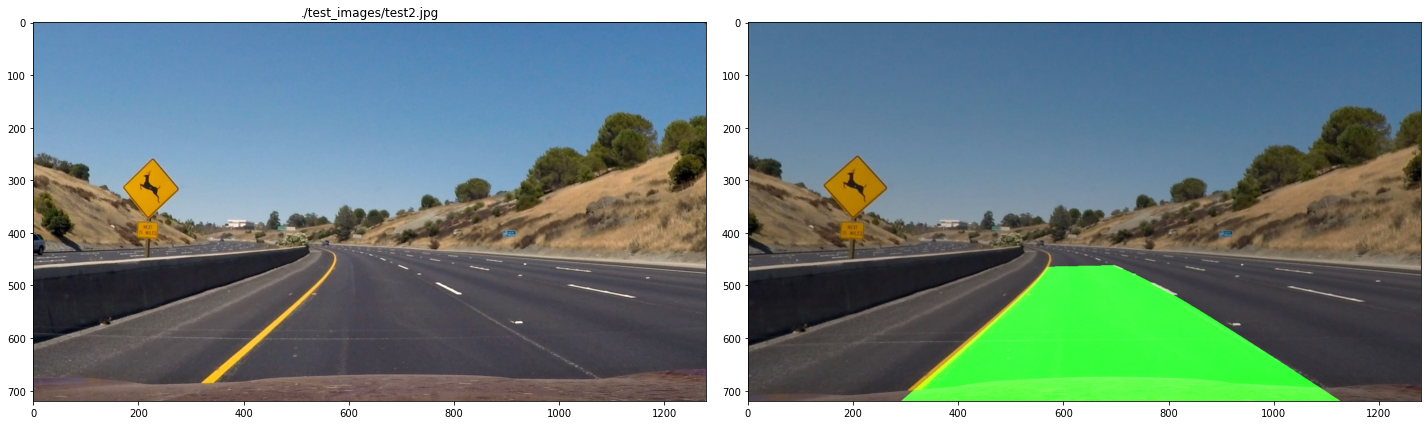

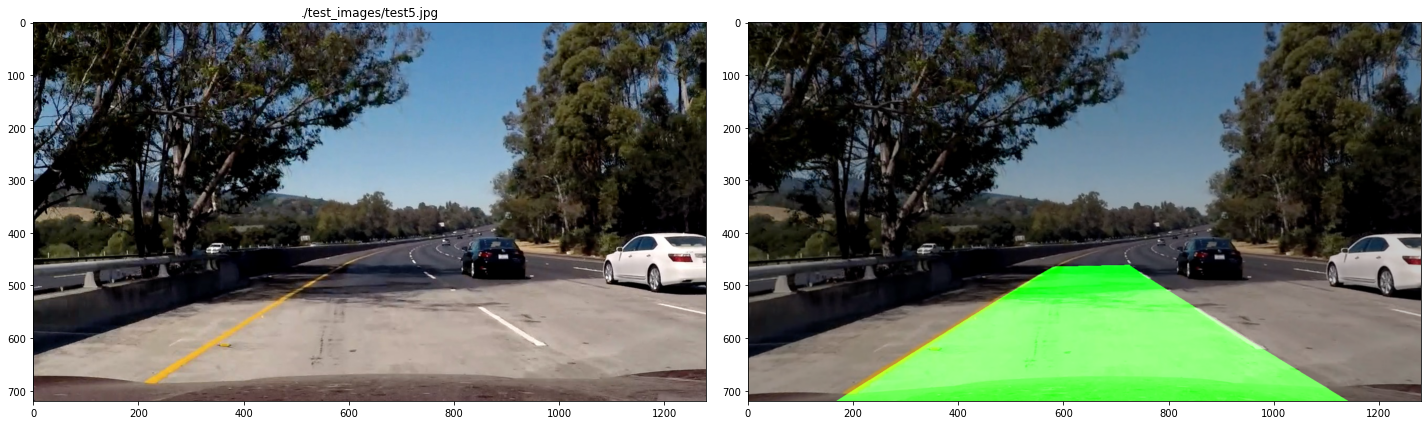

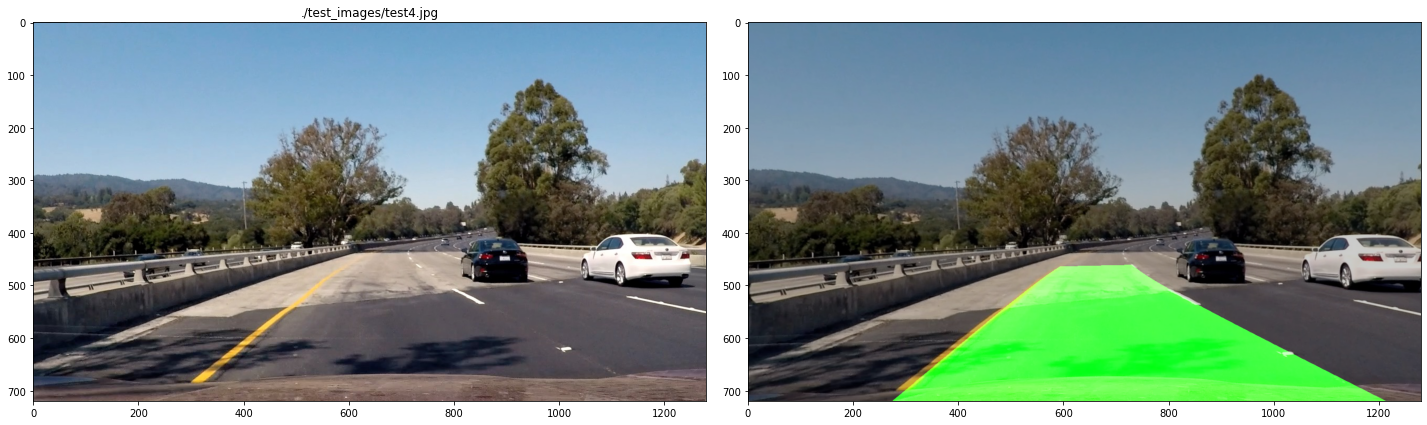

In [483]:
test_images = glob.glob('./test_images/*.jpg')
for img_file in test_images:
    img = mpimg.imread(img_file)
    result = pipeline(img, sx_thresh=(20, 100), s_thresh=(100, 255), h_thresh=(80, 255))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    fig.tight_layout()
    ax1.imshow(img)
    ax1.set_title(img_file)
    ax2.imshow(result)

In [486]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [484]:
def process_image(image):
    result = pipeline(image)
    return result

In [492]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile("output_videos/project.mp4", audio=False)

t:   0%|          | 3/1260 [00:00<00:45, 27.48it/s, now=None]

Moviepy - Building video output_videos/project.mp4.
Moviepy - Writing video output_videos/project.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project.mp4
CPU times: user 2min 33s, sys: 1min 7s, total: 3min 40s
Wall time: 1min 23s


In [493]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos/project.mp4"))